In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt



def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True,block_norm='L2-Hys'):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(32, 32)):
    """
    Return binned color features.
    This is just the resized image, unrolled in a feature vector.
    """
    features = cv2.resize(img, size).ravel()
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Compute the color histogram features of a given image `img`.
    Histogram is computed for each channel separately: then histograms are \
    concatenated and resulting feature vector is returned.
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def image_to_features(image, feat_extraction_params):
    """
    Extract and return the feature vector from given image.

    Parameters
    ----------
    image : ndarray
        input image on which perform feature extraction.

    feat_extraction_params : dict
        dictionary of parameters that control the process of feature extraction.

    Returns
    -------
    features : ndarray
        array of features which describes the input image.
    """
    color_space = feat_extraction_params['color_space']
    spatial_size = feat_extraction_params['spatial_size']
    hist_bins = feat_extraction_params['hist_bins']
    orient = feat_extraction_params['orient']
    pix_per_cell = feat_extraction_params['pix_per_cell']
    cell_per_block = feat_extraction_params['cell_per_block']
    hog_channel = feat_extraction_params['hog_channel']
    spatial_feat = feat_extraction_params['spatial_feat']
    hist_feat = feat_extraction_params['hist_feat']
    hog_feat = feat_extraction_params['hog_feat']

    image_features = []

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else:
        feature_image = np.copy(image)

    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        image_features.append(spatial_features)

    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        image_features.append(hist_features)

    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        image_features.append(hog_features)

    return np.concatenate(image_features)


def extract_features_from_file_list(file_list, feat_extraction_params):
    """
    Extract features from a list of images

    Parameters
    ----------
    file_list : list
        list of files path on which feature extraction process must be performed.

    feat_extraction_params : dict
        dictionary of parameters that control the process of feature extraction.

    Returns
    -------
    features : list
        list of feature array, one for each input file.
    """
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of image files
    for file in file_list:

        resize_h, resize_w = feat_extraction_params['resize_h'], feat_extraction_params['resize_w']
        image = cv2.resize(cv2.imread(file), (resize_w, resize_h))

        # compute the features of this particular image, then append to the list
        file_features = image_to_features(image, feat_extraction_params)
        features.append(file_features)

    return features


def convert_color(image, dest_colorspace='YCrCb'):
    """
    Convert image colorspace (wrapper to `cv2.cvtColor` for code readability.
    """
    if dest_colorspace == 'YCrCb':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    elif dest_colorspace == 'YUV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    elif dest_colorspace == 'LUV':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif dest_colorspace == 'grayscale':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return image


def find_cars(image, y_start, y_stop, scale, svc, feature_scaler, feat_extr_params):
    """
    Extract features from the input image using hog sub-sampling and make predictions on these.

    Parameters
    ----------
    image : ndarray
        Input image.
    y_start : int
        Lower bound of detection area on 'y' axis.
    y_stop : int
        Upper bound of detection area on 'y' axis.
    scale : float
        Factor used to subsample the image before feature extraction.
    svc : Classifier
        Pretrained classifier used to perform prediction of extracted features.
    feature_scaler : sklearn.preprocessing.StandardScaler
        StandardScaler used to perform feature scaling at training time.
    feat_extr_params : dict
        dictionary of parameters that control the process of feature extraction.

    Returns
    -------
    hot_windows : list
        list of bounding boxes (defined by top-left and bottom-right corners) in which cars have been detected
    """
    hot_windows = []

    resize_h = feat_extr_params['resize_h']
    resize_w = feat_extr_params['resize_w']
    color_space = feat_extr_params['color_space']
    spatial_size = feat_extr_params['spatial_size']
    hist_bins = feat_extr_params['hist_bins']
    orient = feat_extr_params['orient']
    pix_per_cell = feat_extr_params['pix_per_cell']
    cell_per_block = feat_extr_params['cell_per_block']

    draw_img = np.copy(image)

    image_crop = image[y_start:y_stop, :, :]
    image_crop = convert_color(image_crop, dest_colorspace=color_space)

    if scale != 1:
        imshape = image_crop.shape
        image_crop = cv2.resize(image_crop, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = image_crop[:, :, 0]
    ch2 = image_crop[:, :, 1]
    ch3 = image_crop[:, :, 2]

    # Define blocks and steps as above
    n_x_blocks = (ch1.shape[1] // pix_per_cell) - 1
    n_y_blocks = (ch1.shape[0] // pix_per_cell) - 1

    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(n_x_steps):
        for yb in range(n_y_steps):
            y_pos = yb * cells_per_step
            x_pos = xb * cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_feat2 = hog2[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_feat3 = hog3[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(image_crop[y_top:y_top + window, x_left:x_left + window], (resize_w, resize_h))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = feature_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(x_left * scale)
                ytop_draw = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                tl_corner_draw = (xbox_left, ytop_draw + y_start)
                br_corner_draw = (xbox_left + win_draw, ytop_draw + win_draw + y_start)

                cv2.rectangle(draw_img, tl_corner_draw, br_corner_draw, (0, 0, 255), 6)

                hot_windows.append((tl_corner_draw, br_corner_draw))

    return hot_windows




/Users/likangning/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


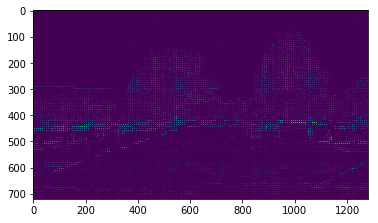

In [2]:
if __name__ == '__main__':

    ystart = 400
    ystop = 656
    scale = 1.5

    from config import feat_extraction_params as feat_extr_params

    img = cv2.imread('test_images/test1.jpg', cv2.IMREAD_COLOR)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    color_space = feat_extr_params['color_space']
    spatial_size = feat_extr_params['spatial_size']
    hist_bins = feat_extr_params['hist_bins']
    orient = feat_extr_params['orient']
    pix_per_cell = feat_extr_params['pix_per_cell']
    cell_per_block = feat_extr_params['cell_per_block']
    hog_channel = feat_extr_params['hog_channel']
    spatial_feat = feat_extr_params['spatial_feat']
    hist_feat = feat_extr_params['hist_feat']
    hog_feat = feat_extr_params['hog_feat']

    test1,test2=get_hog_features(img_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    plt.imshow(test2)


    #out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)





